In [1]:
from data_rnn import load_brackets
from torch import nn
import torch.optim as optim
import torch
import random

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [2]:
x_train, (i2w, w2i) = load_brackets(n=150_000, seed=0)

In [3]:
len(x_train)

150000

In [4]:
len(x_train[-1])

1022

In [5]:
print(''.join([i2w[i] for i in x_train[97000]]))

(())


In [6]:
i2w

['.pad', '.start', '.end', '.unk', ')', '(']

In [7]:
len(i2w)

6

In [8]:
max_tokens = 20000
batches = []

start_seq_len = len(x_train[-1]) + 2
batch_x = torch.zeros(size=(max_tokens//start_seq_len, start_seq_len), dtype=torch.long)
num_sequences = 0
for seq in reversed(x_train):
    if num_sequences == batch_x.shape[0]:
        batch_y = torch.zeros_like(batch_x, dtype=torch.long)
        batch_y[:, :-1] = batch_x[:, 1:]
        batches.append((batch_x, batch_y))
        seq_len = len(seq) + 2
        batch_x = torch.zeros(size=(max_tokens//seq_len, seq_len), dtype=torch.long)
        num_sequences = 0
    seq = [1] + seq + [2]
    batch_x[num_sequences, :len(seq)] = torch.tensor(seq)
    num_sequences += 1
batches.append((batch_x, batch_y))

print(batches[0][0].shape)
print(batches[0][1].shape)

torch.Size([19, 1024])
torch.Size([19, 1024])


In [9]:
random.shuffle(batches)
print(batches[0][0].shape)
batches[0][1].shape

torch.Size([5000, 4])


torch.Size([5000, 4])

## Model

In [10]:
class AutoregressModel(nn.Module):
    def __init__(self, embedding_dim, hidden_size, dropout, vocab_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.out = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, input):
        embeddings = self.embedding(input)
        hidden, _ = self.lstm(embeddings)
        out = self.out(hidden)
        return out



In [11]:
import torch.distributions as dist
import torch.nn.functional as F
def sample(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome logits
    :param temperature: Sampling temperature. 1.0 follows the given
    distribution, 0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """
    if temperature == 0.0:
        return lnprobs.argmax(dim=1)
    p = F.softmax(lnprobs / temperature, dim=1)
    cd = dist.Categorical(p)
    return cd.sample()

In [12]:
combos = [
    ['.start','(','(','(','(','(','('],
    ['.start','(','(','(','(','(',')'],
    ['.start','(','(','(','(',')',')'],
    ['.start','(','(','(',')',')','('],
    ['.start','(','(',')','(',')','('],
    ['.start','(','(','(',')',')','('],
    ['.start','(','(',')','(','(','('],
    ['.start','(','(',')','(',')','('],
    ['.start','(','(',')','(','(',')'],
    ['.start','(','(','(','(',')','('],
    ]

def print_examples(max_generation_length):
    # Create a tensor to hold all of the sequences
    seq = torch.zeros((len(combos), max_generation_length), dtype=torch.long)

    # Create a tensor to hold the number of steps taken to generate each sequence
    steps = torch.zeros((len(combos)), dtype=torch.long)

    # Initialize the input sequences with the first characters of each combo
    for i, combo in enumerate(combos):
        for c, char in enumerate(combo):
            seq[i, c] = w2i[char]

    # Process all of the sequences in one batch
    with torch.no_grad():
        for t in range(7, max_generation_length):
            # Use the autoregressive model to predict the next characters in each sequence
            pred = autoregressmodel(seq[:, :t])
            next_chars = sample(lnprobs=pred[:, -1,:], temperature=0.1)

            # Stop generating a sequence if it reaches the end token or if it is longer than the maximum generation length
            mask = (next_chars == 2) | (t == max_generation_length-1)
            steps[(steps == 0) & mask] = t
            seq[:, t] = next_chars
            if steps.min() > 1:
                break


        # Print the results for each sequence
        for i in range(len(combos)):
            print(f"lenght: {int(steps[i])}")
            print(''.join([i2w[char] for char in seq[i, :steps[i]+1]]), end=" ")
            # Get the counts of each character in each sequence
            counts = torch.bincount(seq[i, :steps[i]+1], minlength=6)
            if int(steps[i]) == max_generation_length-1:
                print("Longer than max_generation_length --> correctness can not be evaluated")
            elif counts[4] == counts[5]:
                print("correct :)")
            else: print("incorrect :(")

In [13]:
writer = SummaryWriter('runs/brackets_gradient_norms_clipped_max0.1_4')

n_epochs = 20
lr = 0.01
max_lr = 0.05
weight_decay = 0.0001

hidden_size = 100
embedding_dim = 50
dropout=0
vocab_size = len(i2w)
num_layers = 1
max_generation_length = 1500 # TODO

print(f"Batches per epoch: {len(batches)}")

autoregressmodel = AutoregressModel(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    dropout=dropout,
    vocab_size=vocab_size,
    num_layers=num_layers)

writer.add_graph(autoregressmodel, batches[0][0])

criterion = nn.CrossEntropyLoss(ignore_index=0) # TODO reduction="sum"
optimizer = optim.Adam(autoregressmodel.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(batches), epochs=n_epochs)

train_loss = []
gradient_norms = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    for i, data in enumerate(batches):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = autoregressmodel(inputs)
        outputs = torch.moveaxis(outputs, 1, 2)
        loss = criterion(outputs, labels)
        writer.add_scalar("Training loss", loss, (i+1)+len(batches)*epoch)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # clip gradient norms
        nn.utils.clip_grad_norm_(autoregressmodel.parameters(), max_norm=0.1, norm_type=2)

        #track gradient norms
        total_gradient_norm = 0
        for param in autoregressmodel.parameters():
            total_gradient_norm += param.grad.detach().data.norm()
        writer.add_scalar("Total gradient norm", total_gradient_norm, (i+1)+len(batches)*epoch)

        train_loss.append(loss)
        gradient_norms.append(total_gradient_norm)

        
    print_examples(max_generation_length)# TODO 

            
        
print("\nDONE\n")

Batches per epoch: 86
Epoch 1/20
lenght: 1499
.start(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((()((((((((((((((((((((()((((((((((((((((((((((((((((((((((((((((((((((((((((((((())((((((((()(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((()))((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((()((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((()((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((()((((((()((((((((((((((((())((((()((((((((((((((((((((((((((((((((((((((((((((((((((((()(((((((((((((((((((((((((((((((((((((((((()(((((((((((((((((((((((((((((((((((((((())))))(((((((((((((((((((((()))((((((((((((((((((((((((((((())((((((((((((((()((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((()(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((

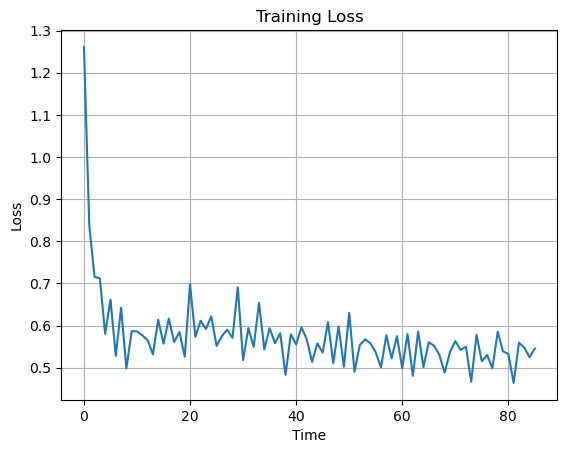

In [28]:
import matplotlib.pyplot as plt 

#train_loss = [loss.detach() for loss in train_loss]
#train_loss = [float(loss) for loss in train_loss]

n = 20

train_loss_avg = [sum(train_loss[i:i+n])/n for i in range(0,len(train_loss),n)]

plt.plot(train_loss_avg)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Time")
plt.grid()
plt.show()

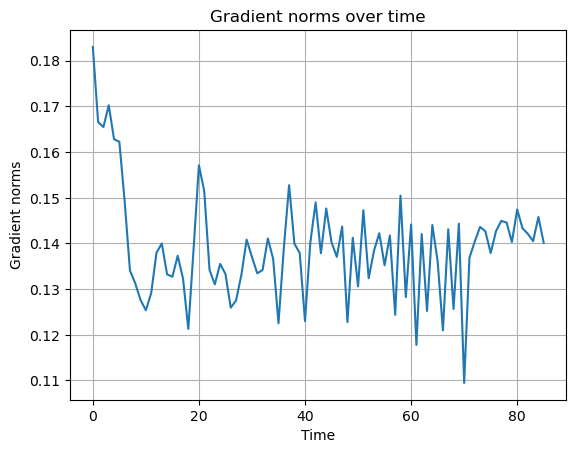

In [29]:
gradient_norms_avg = [sum(gradient_norms[i:i+n])/n for i in range(0,len(gradient_norms),n)]


plt.plot(gradient_norms_avg)
plt.title("Gradient norms over time")
plt.ylabel("Gradient norms")
plt.xlabel("Time")
plt.grid()
plt.show()